In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL

In [2]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf

from IPython import display

In [3]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [4]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:30000]
# You should also define a samller subset of the images for testing..
# TODO
test_images = images[30000:35000]

# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images to train on


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

In [6]:
def prepare_data(input_ds):
    # change shape to 28x28
    ds = input_ds.map(lambda img: tf.reshape(img, (28,28, 1)))
    # normalize values
    ds = ds.map(lambda img: tf.cast(img, tf.float32)/128. - 1.)

    ds = ds.shuffle(1000)
    ds = ds.batch(32)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [7]:
train_ds = prepare_data(train_dataset)
test_ds = prepare_data(test_dataset)

In [8]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, input_shape=(28,28,1))
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3)
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3)
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(1, activation="sigmoid")
        

    @tf.function
    def call(self, x, training):
        x = self.conv1(x)
        x = self.batch1(x, training)
        x = self.conv2(x)
        x = self.batch2(x, training)
        x = self.conv3(x)
        x = self.batch3(x, training)
        x = self.flatten(x)
        return self.dense1(x)

In [9]:
class Generator(tf.keras.Model):
    def __init__(self, latent_space=100):
        super().__init__()
        
        self.dense1 = tf.keras.layers.Dense(units=7*7*32, input_shape=(latent_space,))
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.reshape = tf.keras.layers.Reshape(target_shape=(7,7,32))
        self.convt1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2, strides=(2,2), padding="same")
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.convt2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2, strides=(2,2), padding="same")
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding="same", activation="tanh")


    @tf.function
    def call(self, x, training):
        x = self.dense1(x)
        x = self.batch1(x, training)
        x = self.reshape(x)
        x = self.convt1(x)
        x = self.batch2(x, training)
        x = self.convt2(x)
        x = self.batch3(x, training)
        return self.conv1(x)


In [10]:
@tf.function
def training_step(data, generator, discriminator, gen_optimizer, disc_optimizer, gen_metric, disc_metric):
    loss = tf.keras.losses.BinaryCrossentropy()
    
    for batch in data:
        noise = tf.random.normal([tf.shape(batch)[0], 100])

        with tf.GradientTape() as tape_disc, tf.GradientTape() as tape_gen:          
            generated_batch = generator(noise, training=True)

            generated_batch_pred = discriminator(generated_batch, training=True)
            batch_pred = discriminator(batch, training=True)

            loss_gen = loss(tf.ones_like(generated_batch_pred), generated_batch_pred) 
            loss_disc = loss(tf.zeros_like(generated_batch_pred), generated_batch_pred) + loss(tf.ones_like(batch_pred), batch_pred) 

        gen_gradients = tape_gen.gradient(loss_gen, generator.trainable_variables)
        disc_gradients = tape_disc.gradient(loss_disc, discriminator.trainable_variables)

        gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
        
        gen_metric.update_state(loss_gen)
        disc_metric.update_state(loss_disc)

Current generator loss: 10.55835247039795
Current discriminator loss: 2.7876713275909424


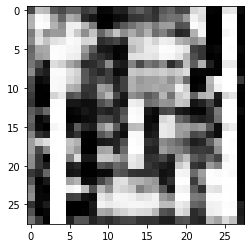

Current generator loss: 8.294076919555664
Current discriminator loss: 4.317038059234619


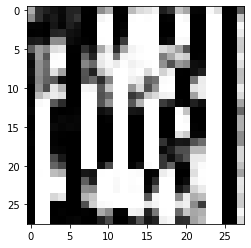

Current generator loss: 4.1470417976379395
Current discriminator loss: 1.6151493787765503


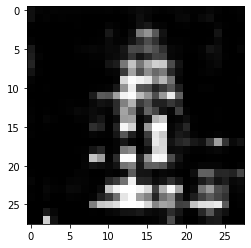

Current generator loss: 1.9569236040115356
Current discriminator loss: 1.5013344287872314


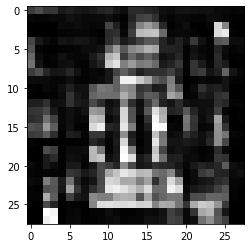

Current generator loss: 1.8371435403823853
Current discriminator loss: 1.77067232131958


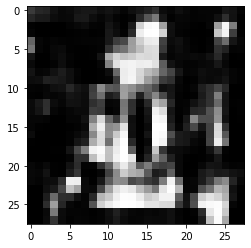

Current generator loss: 1.505799412727356
Current discriminator loss: 1.471137523651123


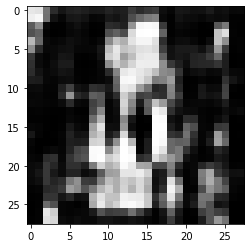

Current generator loss: 2.1118898391723633
Current discriminator loss: 1.6380505561828613


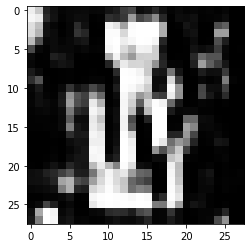

Current generator loss: 1.3881595134735107
Current discriminator loss: 1.509392499923706


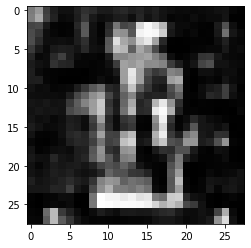

Current generator loss: 1.4560749530792236
Current discriminator loss: 1.5777956247329712


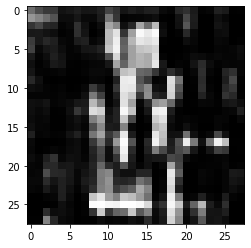

Current generator loss: 1.28466796875
Current discriminator loss: 1.630143165588379


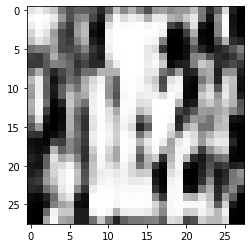

In [11]:
epochs = 10

generator = Generator()
discriminator = Discriminator()

optimizer_gen = tf.keras.optimizers.Adam()
optimizer_disc = tf.keras.optimizers.Adam()

loss_gen = tf.keras.metrics.Mean('generator_loss')
loss_disc = tf.keras.metrics.Mean('discriminator_loss')

example_input = tf.expand_dims(tf.random.normal([100]),0)

for _ in range(epochs):    
    # Training
    training_step(train_ds, generator, discriminator, optimizer_gen, optimizer_disc, loss_gen, loss_disc)

    cur_loss_gen = loss_gen.result()
    cur_loss_disc = loss_disc.result()

    print(f"Current generator loss: {cur_loss_gen}")
    print(f"Current discriminator loss: {cur_loss_disc}")

    loss_gen.reset_states()
    loss_disc.reset_states()

    test_image = generator(example_input)
    plt.imshow(test_image.numpy().reshape(28,28),cmap= "gray")
    plt.show()
  
  